<a href="https://colab.research.google.com/github/ipsitapatra7149/diya_bati_ss/blob/main/age_predict_30_mar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Shape: (266, 40)

Missing Values:
Age Group                                        0
Gender                                           0
Height                                           0
Weight                                           0
Current Occupation                               0
Age at Diagnosis                                 0
Fasting Blood Sugar                              0
Postprandial Blood Sugar                         0
Average Blood sugar in 3 months                  0
HbA1c Levels                                     0
Use of Medication                               59
Frequency of Doctor Visits                       0
Frequency of Blood Sugar Testing                 0
Other Chronic Conditions                        56
Meal Frequency                                   0
Sugar Consumption                                0
Oily Food Consumption                            0
Processed Food Consumption                       0
Food Source Preference                     

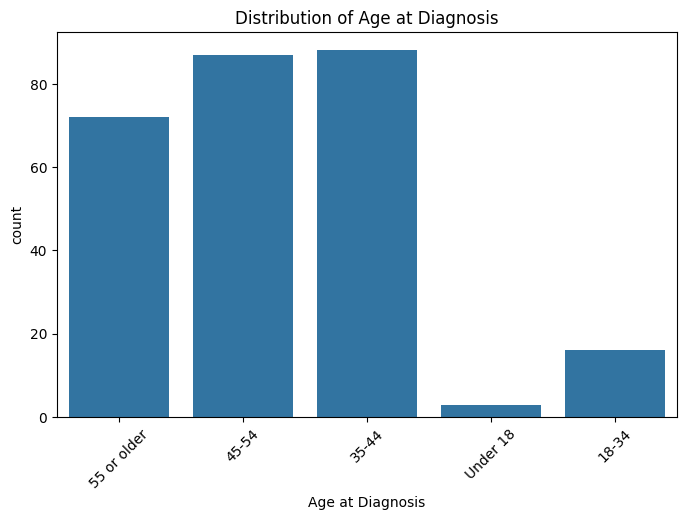


Model Performance:
Mean Absolute Error (MAE): 9.48
Mean Squared Error (MSE): 126.09
Root Mean Squared Error (RMSE): 11.23
R-squared (R²): 0.23

Top 20 Features by Importance:
                                               Feature  Importance
82                     Maternal_Age at Diagnosis_18-34    0.082129
104              Maternal_Dietary Pattern_High Protein    0.048905
28                  Frequency of Doctor Visits_Monthly    0.044101
43           Meal Frequency_Rarely, I often skip meals    0.037609
155   Financial Burden of Diabetes Treatment_Very high    0.036581
6                                      Age Group_35-44    0.035544
133                Paternal_Dietary Pattern_High Sugar    0.034965
5                                      Age Group_25-34    0.031238
107  Maternal_Dietary Pattern_Keto/Low Carb High Fa...    0.024624
145  Stress Levels Related to Diabetes Management_V...    0.020689
149  Support from Family and Friends_Not very suppo...    0.018450
142  Stress Levels R

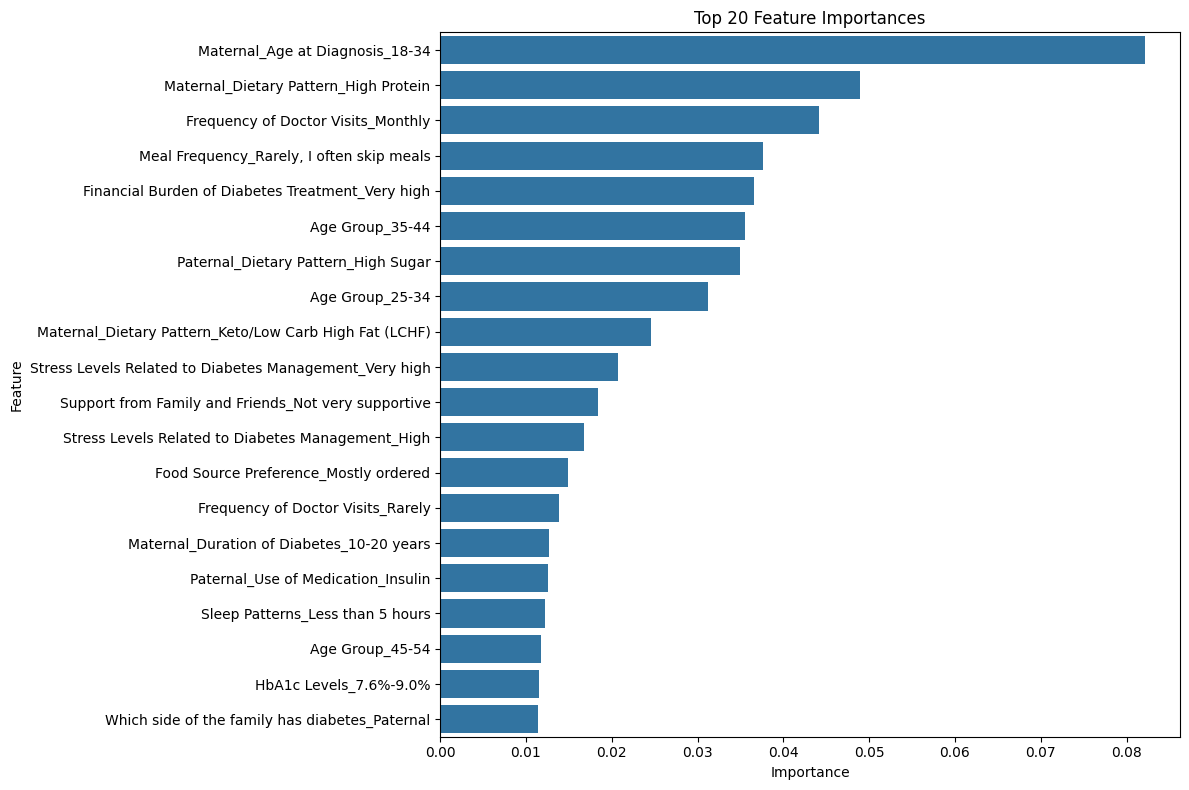

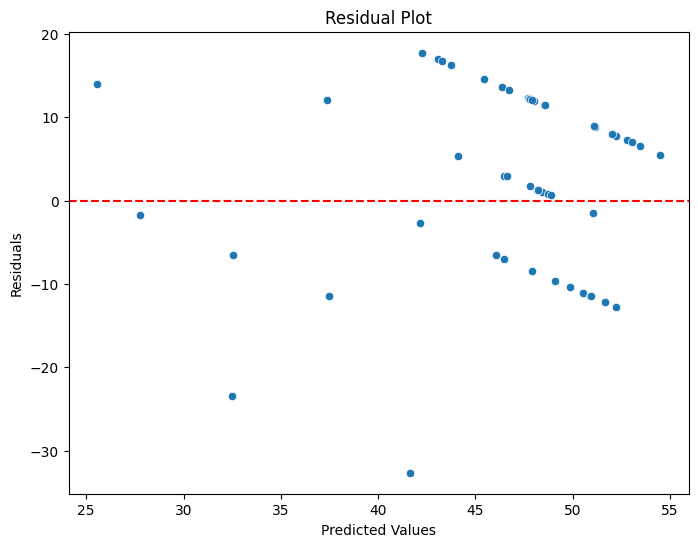

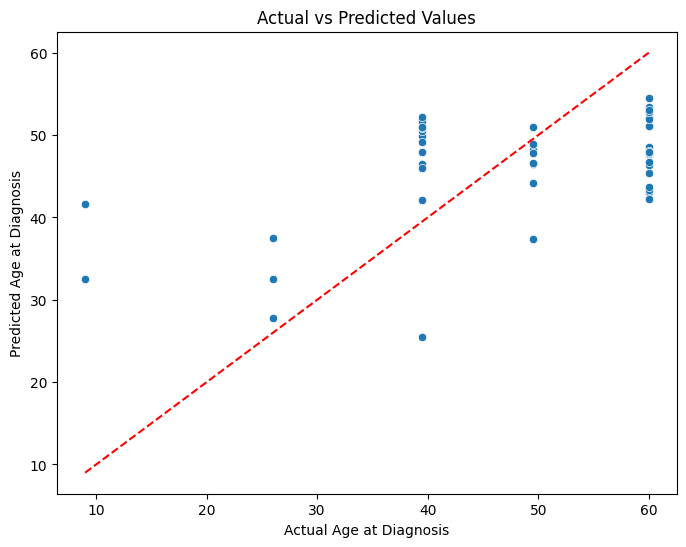

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "Diabetic_Merged.xlsx"
df = pd.read_excel(file_path)

# Data Exploration
print("Data Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe(include='all'))

# Target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Age at Diagnosis', data=df)
plt.title('Distribution of Age at Diagnosis')
plt.xticks(rotation=45)
plt.show()

# Convert Age at Diagnosis to numerical (taking midpoint of ranges)
def age_to_numeric(x):
    if pd.isna(x):
        return np.nan
    if x == 'Under 18':
        return 9
    elif x == '18-34':
        return (18 + 34)/2
    elif x == '35-44':
        return (35 + 44)/2
    elif x == '45-54':
        return (45 + 54)/2
    elif x == '55 or older':
        return 60  # Approximation
    else:
        return np.nan

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)

# Split data
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature Engineering functions
def create_features(data):
    data = data.copy()
    # Create BMI feature
    data['BMI'] = data['Weight'] / ((data['Height']/100) ** 2)

    # Convert HbA1c to numerical
    def hba1c_to_numeric(x):
        if pd.isna(x):
            return np.nan
        if x == 'Below 5.7%':
            return 5.35
        elif x == '5.7%-6.4%':
            return (5.7 + 6.4)/2
        elif x == '6.5%-7.5%':
            return (6.5 + 7.5)/2
        elif x == '7.6%-9.0%':
            return (7.6 + 9.0)/2
        elif x == '9.1% or higher':
            return 9.5
        else:
            return np.nan

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    return data

# Apply feature engineering separately to train and test
X_train = create_features(X_train)
X_test = create_features(X_test)

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove engineered features from numeric features
numeric_features = [f for f in numeric_features if f not in ['BMI', 'HbA1c_numeric']]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('new_features', 'passthrough', ['BMI', 'HbA1c_numeric'])
    ])

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mae'
    ))
])

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Feature Importance
onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_columns) + ['BMI', 'HbA1c_numeric']

importances = model.named_steps['regressor'].feature_importances_

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Age at Diagnosis')
plt.ylabel('Predicted Age at Diagnosis')
plt.show()